In [1]:
from qdrant_client.http.models import HnswConfig, HnswConfigDiff
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable.passthrough import RunnablePassthrough
from langchain_core.output_parsers.string import StrOutputParser
import uuid

In [2]:
import spacy
import networkx as nx
from itertools import combinations

class GraphConstructor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")  # Tải mô hình NLP để nhận diện thực thể
        self.graph = nx.Graph()

    def add_text_to_graph(self, text):
        doc = self.nlp(text)
        entities = [ent.text for ent in doc.ents]  # Tìm các thực thể (entities)

        for entity1, entity2 in combinations(entities, 2):
            if not self.graph.has_edge(entity1, entity2):
                self.graph.add_edge(entity1, entity2, weight=1)
            else:
                self.graph[entity1][entity2]["weight"] += 1  # Tăng trọng số nếu có nhiều kết nối

    def visualize_graph(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray")
        plt.show()

    def get_graph(self):
        return self.graph


In [3]:
from typing import List
from sentence_transformers import CrossEncoder
from qdrant_client.http.models import Filter, FieldCondition, MatchValue
from rank_bm25 import BM25Okapi

class Qdrant:
    def __init__(self, host = "10.100.140.54", port = 6333):
        self.client = QdrantClient(host= host, port= port)
        self.reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

    def create_collection(self, collection_name):
        existing_collections = [col.name for col in self.client.get_collections().collections]
        if collection_name not in existing_collections:
            self.client.create_collection(
                collection_name=collection_name,
                vectors_config=VectorParams(
                    size=len(embeddings.embed_query("sample text")), 
                    distance=Distance.COSINE
                ),
                hnsw_config=HnswConfigDiff(
                    m=16,                    # Number of connections per node
                    ef_construct=100,       # Higher value = better recall
                    full_scan_threshold=10000  # Adding the missing required field
                )
            )


    def insert_documents(self, collection_name: str, doc_chunks: List, embeddings):
        vectors = [
            embeddings.embed_query(chunk.page_content) for chunk in doc_chunks
        ]
        payloads = [
            {"id": str(uuid.uuid4()), "text": chunk.page_content} for chunk in doc_chunks
        ]
        
        points = [
            PointStruct(id=payload["id"], vector=vectors[i], payload=payload) for i, payload in enumerate(payloads)
        ]

        # Sử dụng upsert thay vì upload_collection
        self.client.upsert(
            collection_name=collection_name,
            points=points
        )


    def search_database(self, collection_name, question, embeddings, limit=3):
        query_vector = embeddings.embed_query(question)
        search_result = self.client.query_points(
            collection_name=collection_name,
            query=query_vector,
            limit=limit
        ).points
        if not search_result:
            return "Không tìm thấy kết quả."
        try:
            text_result = "\n\n".join(hit.payload['text'] for hit in search_result)
            return text_result
        except KeyError as e:
            return "Lỗi: Cấu trúc payload không hợp lệ."
        except Exception as e:
            return "Lỗi: Không thể xử lý kết quả tìm kiếm."

    def rerank_documents(self, question: str, documents: List[str], top_k: int = 3) -> List[str]:
        """
        Rerank a list of documents based on relevance to the question using CrossEncoder.
        """
        if not documents:
            return []
        
        rerank_inputs = [[question, doc] for doc in documents]
        scores = self.reranker.predict(rerank_inputs, batch_size=32)
        sorted_pairs = sorted(zip(scores, documents), reverse=True)
        return [doc for _, doc in sorted_pairs][:top_k]
    
    def search_database_fusion_bm250(self, collection_name, question, embeddings, doc_chunks, limit=5):
        """
        Kết hợp BM25 và Vector Search, sau đó rerank kết quả dựa trên mức độ liên quan với câu hỏi.
        """
        # 🔍 BM25 Search
        texts = [doc.page_content for doc in doc_chunks]  # Lấy toàn bộ văn bản đã index
        tokenized_corpus = [text.split() for text in texts]
        bm25 = BM25Okapi(tokenized_corpus)
        bm25_scores = bm25.get_scores(question.split())
    
        top_bm25_indices = sorted(range(len(bm25_scores)), key=lambda i: bm25_scores[i], reverse=True)[:limit]
        top_bm25_results = [texts[i] for i in top_bm25_indices]
    
        # 🔍 Vector Search trong Qdrant
        query_vector = embeddings.embed_query(question)
        
        try:
            search_result = self.client.query_points(
                collection_name=collection_name,
                query_vector=query_vector,
                limit=limit,
                with_payload=True
            )
        except Exception as e:
            return f"Lỗi khi truy vấn vector database: {e}"
    
        if not search_result.points:
            vector_results = []
        else:
            vector_results = [hit.payload['text'] for hit in search_result.points if 'text' in hit.payload]
    
        # 🌀 Fusion Search (Kết hợp BM25 + Vector Search có trọng số)
        combined_results = top_bm25_results + vector_results
        combined_results = list(set(combined_results))  # Loại bỏ trùng lặp
    
        # 🏆 Rerank toàn bộ kết quả
        reranked_docs = self.rerank_documents(question, combined_results, top_k=limit)
    
        return "\n\n".join(reranked_docs[:limit])



In [4]:
class GraphRetriever:
    def __init__(self, graph, qdrant_client, collection_name, embeddings, doc_chunks):
        self.graph = graph
        self.qdrant_client = qdrant_client
        self.collection_name = collection_name
        self.embeddings = embeddings
        self.doc_chunks = doc_chunks

    def query_graph(self, query_entity, depth=2):
        """
        Tìm các thực thể liên quan đến query_entity trong đồ thị.
        """
        if query_entity not in self.graph:
            return []

        neighbors = nx.single_source_shortest_path_length(self.graph, query_entity, cutoff=depth)
        related_entities = list(neighbors.keys())

        return related_entities

    def search_with_vector_db(self, question, limit=5):
        """
        Kết hợp BM25 + Vector Search để tìm dữ liệu nếu Graph không có đủ thông tin.
        """
        return self.qdrant_client.search_database_fusion_bm250(
            collection_name=self.collection_name, 
            question=question, 
            embeddings=self.embeddings, 
            doc_chunks=self.doc_chunks, 
            limit=limit
        )

    def retrieve(self, question):
        """
        Truy vấn trong Graph trước. Nếu không có dữ liệu đầy đủ, fallback sang Vector Search.
        """
        query_entity = question.split()[0]  # Giả sử thực thể chính là từ đầu tiên của câu hỏi
        graph_results = self.query_graph(query_entity)

        if graph_results:
            return " ".join(graph_results)  # Trả về kết quả từ Graph

        # Nếu không có thông tin trong Graph, fallback sang BM25 + Vector Search
        return self.search_with_vector_db(question)


In [5]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers.string import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable.passthrough import RunnablePassthrough

class GraphGenerator:
    def __init__(self, model="deepseek-r1:14b"):
        self.llm = ChatOllama(model=model, temperature=0, streaming=True)

    def generate_answer(self, question, graph_context):
        pipeline = (
            RunnablePassthrough()
            | {"question": lambda x: question, "context": lambda x: graph_context}
            | ChatPromptTemplate.from_template("Câu hỏi: {question}\nDữ liệu từ đồ thị: {context}\nTrả lời:")
            | self.llm
            | StrOutputParser()
        )
        return pipeline.invoke({})

In [6]:
class GraphRAG:
    def __init__(self, document_loader, graph_constructor, graph_retriever, graph_generator):
        self.document_loader = document_loader
        self.graph_constructor = graph_constructor
        self.graph_retriever = graph_retriever
        self.graph_generator = graph_generator

    def process_query(self, question):
        # 🔍 Tìm dữ liệu trong Graph hoặc Vector Database
        retrieved_context = self.graph_retriever.retrieve(question)

        # 🤖 AI tổng hợp câu trả lời dựa trên dữ liệu truy xuất
        final_answer = self.graph_generator.generate_answer(question, retrieved_context)
        
        return final_answer


In [7]:
from langchain.document_loaders import PyMuPDFLoader, WebBaseLoader

class DocumentLoader:
    def __init__(self, file_path=None, url=None):
        self.file_path = file_path
        self.url = url

    def load(self):
        if self.file_path:
            return PyMuPDFLoader(self.file_path).load()
        elif self.url:
            return WebBaseLoader(self.url).load()
        else:
            raise ValueError("Cần cung cấp file_path hoặc URL!")

USER_AGENT environment variable not set, consider setting it to identify your requests.


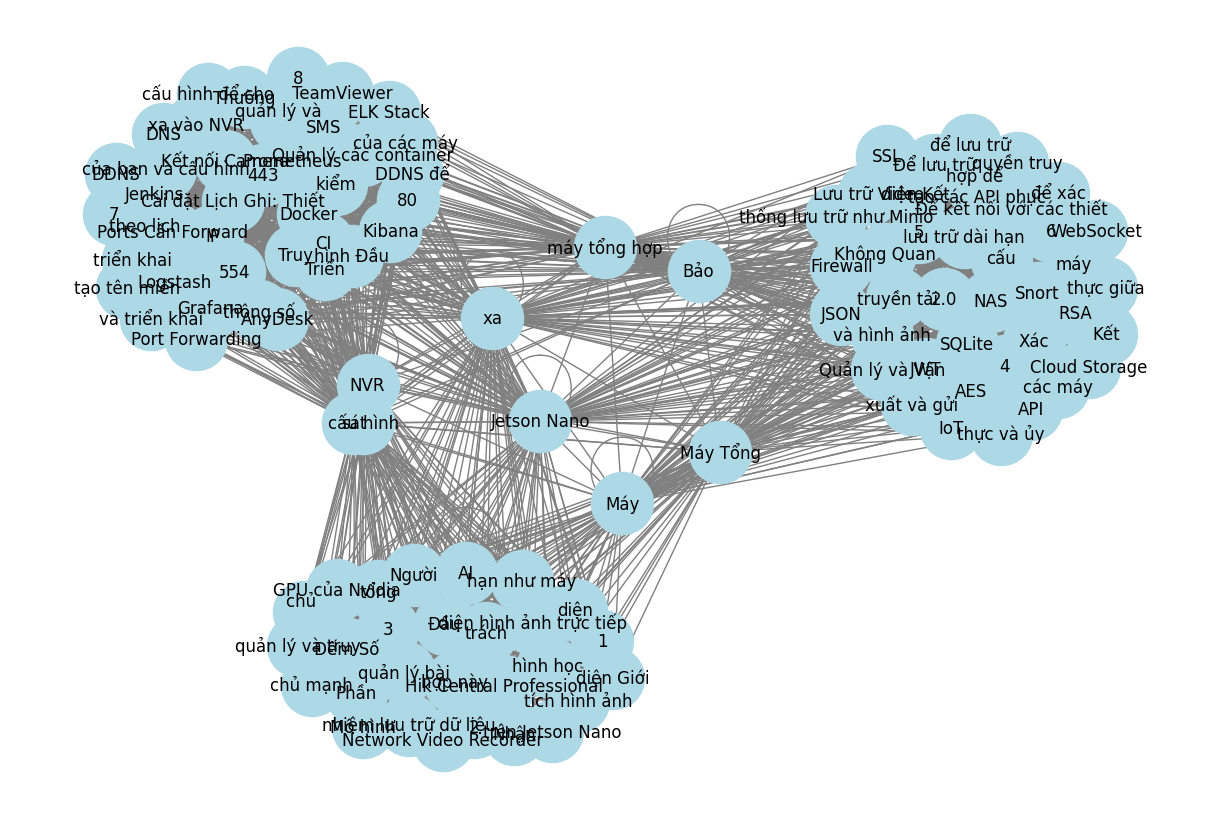

In [8]:
# Bước 1: Load tài liệu
file = "/home/namnh1/rag-llm-chatbot/Quản lý mô hình AI camera.pdf"
doc_loader = DocumentLoader(file_path=file)
documents = doc_loader.load()

# Bước 2: Xây dựng đồ thị từ tài liệu
graph_constructor = GraphConstructor()
for doc in documents:
    graph_constructor.add_text_to_graph(doc.page_content)

# Hiển thị đồ thị
graph_constructor.visualize_graph()
from qdrant_client import QdrantClient
from langchain_ollama import OllamaEmbeddings

# Bước 3: Kết nối với Qdrant và tích hợp Search
qdrant_client = Qdrant()
graph = graph_constructor.get_graph()
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url="http://localhost:11434")
graph_retriever = GraphRetriever(graph, qdrant_client, "collection_name", embeddings, documents)
graph_generator = GraphGenerator()

# Bước 4: Chạy Graph RAG
graph_rag = GraphRAG(doc_loader, graph_constructor, graph_retriever, graph_generator)

In [10]:
# Bước 5: Đặt câu hỏi
question = "what's eVision ? "
response = graph_rag.process_query(question)

print(response)

<think>
Okay, so I'm trying to figure out what "eVision" is. The user asked the question, and there was an error message about querying a vector database with unknown arguments like 'query_vector'. Hmm, that's a bit confusing.

First, I'll think about possible meanings of "eVision". It could be related to vision in some technical context. Maybe it's a software tool or a company product? Or perhaps it's something related to computer vision or AI?

The error message mentions a vector database and an unknown argument 'query_vector'. That makes me think that eVision might be interacting with a database where vectors are stored, and when trying to query, it's passing an unexpected parameter. Maybe the system isn't set up correctly for this kind of query.

I should consider if eVision is part of a larger system or framework. Could it be related to machine learning models where vector representations are used? For example, in image recognition tasks, vectors represent features extracted from 